In [1]:
import os
import sys
import gzip
import tempfile
import matplotlib.pyplot as plt

from ncbi.datasets.openapi import ApiClient as DatasetsApiClient
from ncbi.datasets import GeneApi as DatasetsGeneApi
from ncbi.datasets.package.dataset import GeneDataset

import lakeview as lv

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 100

## Download data

In [2]:
def get_ncbi_gene_fasta(gene_id: int) -> str:
    # https://www.ncbi.nlm.nih.gov/datasets/docs/v1/how-tos/genes/download-gene-data-package/
    with DatasetsApiClient() as api_client:
        gene_api = DatasetsGeneApi(api_client)
        gene_dataset_download = gene_api.download_gene_package(
            [gene_id],
            include_annotation_type=["FASTA_GENE"],
            _preload_content=False,
        )
    with tempfile.NamedTemporaryFile("wb") as tf:
        tf.write(gene_dataset_download.data)
        package = GeneDataset(tf.name)
        for fasta_string, file_name in package.get_files_by_type("GENOMIC_NUCLEOTIDE_FASTA"):
            return fasta_string

In [3]:
IGH_FASTA_PATH = "data/IGH.fasta.gz"
if not os.path.isfile(IGH_FASTA_PATH):
    os.makedirs("data", exist_ok=True)
    IGH_GENE_ID = 3492 # https://www.ncbi.nlm.nih.gov/gene?Db=gene&Cmd=DetailsSearch&Term=3492
    with gzip.open(IGH_FASTA_PATH, 'wt') as f:
        f.write(get_ncbi_gene_fasta(IGH_GENE_ID))

In [4]:
!gunzip -c {IGH_FASTA_PATH} | grep ">"

>NC_000014.9:c106879844-105586437 IGH [organism=Homo sapiens] [GeneID=3492] [chromosome=14]
>NT_187600.1:c1351393-54793 IGH [organism=Homo sapiens] [GeneID=3492] [chromosome=14]
>NG_001019.6:501-1293908 IGH [organism=Homo sapiens] [GeneID=3492] [chromosome=14]
>NC_060938.1:c101155136-99839469 IGH [organism=Homo sapiens] [GeneID=3492] [chromosome=14]


## Load data

In [5]:
with gzip.open(IGH_FASTA_PATH, 'rt') as f1, gzip.open(IGH_FASTA_PATH, 'rt') as f2:
    painter = lv.DotPlot.from_files(
        f1,
        f2,
        x_sequence_name="NC_000014.9:c106879844-105586437",
        y_sequence_name="NT_187600.1:c1351393-54793",
        sample_fraction=0.2
    )


## Plotting

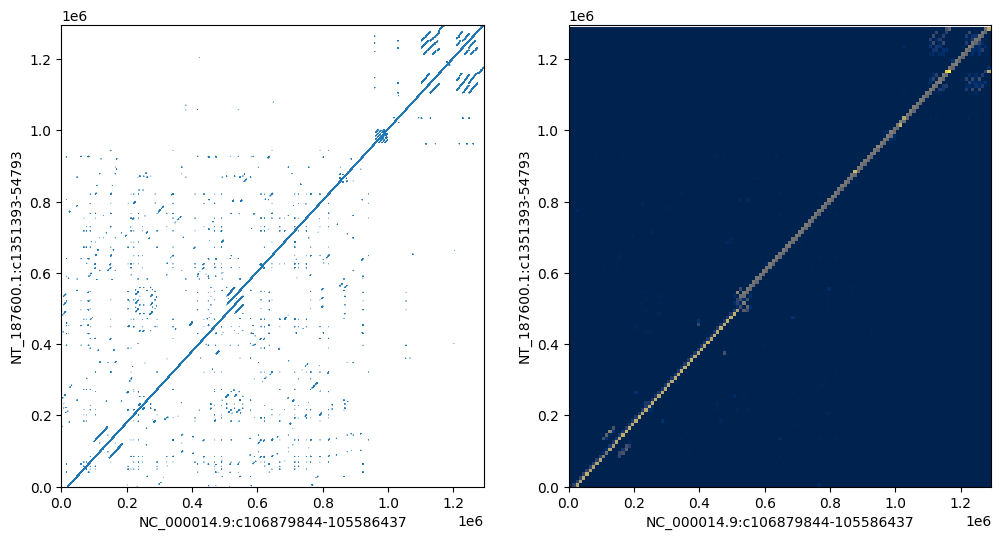

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
painter.draw_dots(axes[0])
painter.draw_heatmap(axes[1], bin_size=10e3, cmin=0)